### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import data into tensorflow dataset object

In [2]:
# Constants
IMAGE_SIZE = 224  # Replace with your desired image size
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/tomatoleaf/Dataset3'  # Path to your dataset directory
CLASS_NAMES = os.listdir(DATASET_DIR)

# Prepare a list of all image paths and corresponding labels
image_paths = []
labels = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [3]:
# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, stratify=train_data['label'], random_state=42)  # 0.25 x 0.8 = 0.2


In [4]:
# Data Augmentation and Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to maintain order for evaluation
)

Found 25618 validated image filenames belonging to 11 classes.
Found 3660 validated image filenames belonging to 11 classes.
Found 3254 validated image filenames belonging to 11 classes.


In [5]:
# Get class indices
class_indices = train_generator.class_indices

# Map class names to their image counts
class_counts_dict = train_data['label'].value_counts().to_dict()

# Create a list of counts in the order of train_generator.class_indices
ordered_counts = [(class_name, class_counts_dict.get(class_name, 0)) for class_name in class_indices.keys()]

# Convert to a DataFrame for better visualization
ordered_counts_df = pd.DataFrame(ordered_counts, columns=['Class Name', 'Image Count'])

# Print the ordered counts
print(ordered_counts_df)



                              Class Name  Image Count
0                         Bacterial_spot         2802
1                           Early_blight         2439
2                            Late_blight         3075
3                              Leaf_Mold         2751
4                     Septoria_leaf_spot         2857
5   Spider_mites Two-spotted_spider_mite         1718
6                            Target_Spot         1799
7          Tomato_Yellow_Leaf_Curl_Virus         1996
8                    Tomato_mosaic_virus         2155
9                                healthy         3037
10                        powdery_mildew          989


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
]

## Building the Model

In [8]:
from tensorflow.keras.models import Model
from keras.layers import Flatten, Dense,TimeDistributed,Conv2D,MaxPooling2D,LSTM,Dropout,Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2 

strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    
    model = Sequential()
    
    # CNN Feature Extraction (using TimeDistributed for sequences)
    model.add(Conv2D(32, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3))) #None for variable sequence length
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    # model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Reshape((1, -1)))
    # LSTM for Temporal Modeling
    model.add(LSTM(64, return_sequences=True,dropout=0.3, recurrent_dropout=0.3)) # Keep return_sequences if you want to stack LSTMs
    model.add(LSTM(32, return_sequences=False,dropout=0.3, recurrent_dropout=0.3))
    
    # Classification
    # Dense Layers and Classification
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))  # Dropout in Dense layer
    model.add(Dense(11, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 200704)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 64)               │      51,396,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,434,315 (196.21 MB)

 Trainable params: 51,434,315 (196.21 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE ,
    # steps_per_epoch = steps_per_epoch,  # Total samples / batch_size
    validation_data=validation_generator,
    # validation_steps = validation_steps,
    epochs=30,
    callbacks = callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


801/801 ━━━━━━━━━━━━━━━━━━━━ 450s 538ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1150 - loss: 2.4549 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1694 - val_loss: 2.3771 - learning_rate: 1.0000e-04
Epoch 2/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 310s 384ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1754 - loss: 2.3252 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2344 - val_loss: 2.1769 - learning_rate: 1.0000e-04
Epoch 3/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 309s 382ms/step - Precision: 0.4193 - Recall: 0.0082 - accuracy: 0.2957 - loss: 2.0617 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2869 - val_loss: 2.0188 - learning_rate: 1.0000e-04
Epoch 4/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 305s 378ms/step - Precision: 0.7897 - Recall: 0.0947 - accuracy: 0.4241 - loss: 1.7365 - val_Precision: 0.5962 - val_Recall: 0.1880 - val_accuracy: 0.3716 - val_loss: 1.7661 - learning_rate: 1.0000e-04
Epo

In [11]:
# Evaluate on train data
train_scores = model.evaluate(train_generator, verbose=0)
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]:.4f}, Train Precision: {train_scores[2]:.4f},Train Recall: {train_scores[3]:.4f}")

Train Loss: 0.5858, Train Accuracy: 0.8194, Train Precision: 0.9021,Train Recall: 0.7510


In [12]:

# Evaluate on test data
test_scores = model.evaluate(test_generator,verbose=0)
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]:.4f},Test Precision: {test_scores[2]:.4f},Test Recall: {test_scores[3]:.4f}")

Test Loss: 1.1057, Test Accuracy: 0.7197,Test Precision: 0.7980,Test Recall: 0.6435


In [13]:
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices


102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step


In [14]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.84      0.76      0.80       356
                        Early_blight       0.82      0.70      0.76       310
                         Late_blight       0.73      0.63      0.68       391
                           Leaf_Mold       0.84      0.79      0.81       349
                  Septoria_leaf_spot       0.70      0.60      0.65       363
Spider_mites Two-spotted_spider_mite       0.71      0.71      0.71       218
                         Target_Spot       0.71      0.47      0.57       228
       Tomato_Yellow_Leaf_Curl_Virus       0.86      0.91      0.88       253
                 Tomato_mosaic_virus       0.94      0.82      0.87       274
                             healthy       0.59      0.97      0.73       386
                      powdery_mildew       0.54      0.74      0.62       126

                            accuracy   

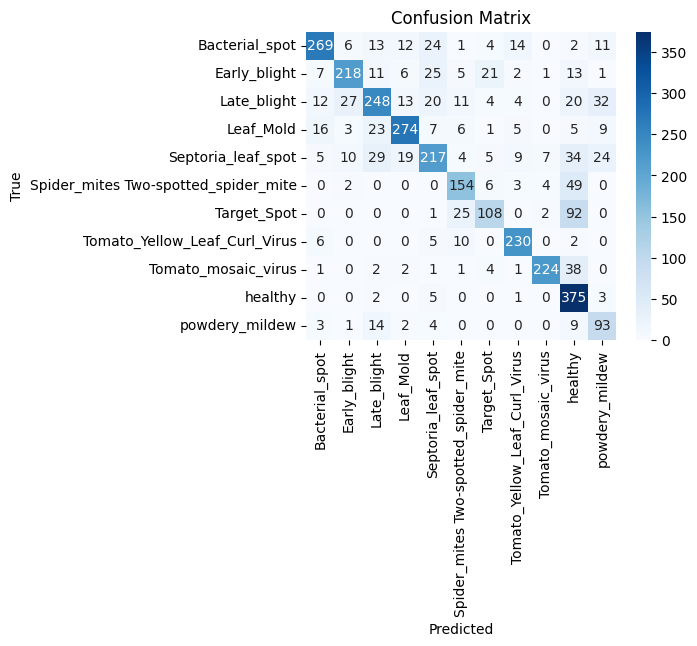

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [16]:
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')  # Weighted average for class imbalance
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")

Overall Accuracy: 0.7406
Overall Precision: 0.7508
Overall Recall: 0.7357
Overall F1-Score: 0.7336


In [17]:
specificity = []

for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

overall_specificity = np.mean(specificity)  # Average specificity

print(f"Overall Specificity: {overall_specificity:.4f}")

Overall Specificity: 0.9738


In [18]:
# Sensitivity (Recall)
def calculate_specificity(cm, CLASS_NAMES):

    # Specificity
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp))

    print("\nPer-Class Specificity:")
    for idx, class_name in enumerate(CLASS_NAMES):
        print(f"Class {class_name}: {specificity[idx]:.4f}")

    return specificity

In [19]:
# print("\n--- Train Data Metrics ---")
specificity = calculate_specificity(cm, CLASS_NAMES)


Per-Class Specificity:
Class Late_blight: 0.9827
Class Tomato_Yellow_Leaf_Curl_Virus: 0.9834
Class Septoria_leaf_spot: 0.9672
Class Early_blight: 0.9814
Class Spider_mites Two-spotted_spider_mite: 0.9682
Class powdery_mildew: 0.9792
Class healthy: 0.9851
Class Bacterial_spot: 0.9870
Class Target_Spot: 0.9953
Class Tomato_mosaic_virus: 0.9079
Class Leaf_Mold: 0.9744


In [20]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Create a DataFrame for the class-wise accuracies
class_accuracy_df = pd.DataFrame({
    "Class": list(test_generator.class_indices.keys()),
    "Accuracy": class_accuracies
})

print("\nClass-wise Accuracies:")
print(class_accuracy_df.to_string(index=False))


Class-wise Accuracies:
                               Class  Accuracy
                      Bacterial_spot  0.755618
                        Early_blight  0.703226
                         Late_blight  0.634271
                           Leaf_Mold  0.785100
                  Septoria_leaf_spot  0.597796
Spider_mites Two-spotted_spider_mite  0.706422
                         Target_Spot  0.473684
       Tomato_Yellow_Leaf_Curl_Virus  0.909091
                 Tomato_mosaic_virus  0.817518
                             healthy  0.971503
                      powdery_mildew  0.738095


### Run prediction on a sample image

In [21]:
import random
from tensorflow.keras.preprocessing import image

random_indices = random.sample(range(len(y_true)), 15)

class_names = list(test_generator.class_indices.keys())

# Iterate through the random indices and display actual and predicted results
for idx in random_indices:
    actual_class = class_names[y_true[idx]]
    predicted_class = class_names[y_pred[idx]]
    print(f"Actual: {actual_class} ,  Predicted: {predicted_class}")

Actual: healthy ,  Predicted: healthy
Actual: Leaf_Mold ,  Predicted: Leaf_Mold
Actual: Late_blight ,  Predicted: Late_blight
Actual: powdery_mildew ,  Predicted: powdery_mildew
Actual: Target_Spot ,  Predicted: Target_Spot
Actual: Late_blight ,  Predicted: Early_blight
Actual: healthy ,  Predicted: healthy
Actual: Late_blight ,  Predicted: Leaf_Mold
Actual: healthy ,  Predicted: healthy
Actual: Septoria_leaf_spot ,  Predicted: Septoria_leaf_spot
Actual: healthy ,  Predicted: healthy
Actual: Early_blight ,  Predicted: Early_blight
Actual: Spider_mites Two-spotted_spider_mite ,  Predicted: healthy
Actual: Late_blight ,  Predicted: Early_blight
Actual: Spider_mites Two-spotted_spider_mite ,  Predicted: Spider_mites Two-spotted_spider_mite
